Let's start with importing TF2 and all relevant dependencies.

In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

2023-04-27 14:22:32.643639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:22:34.259538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-27 14:22:34.259666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-27 14:22:34.259679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

TF Version:  2.11.0
TF Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-27 14:22:36.240127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 14:22:36.354429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 14:22:36.354716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


Let's get as well some images to play with.

71406/71406 [==============================] - 0s 2us/step


2023-04-27 14:22:50.468282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 14:22:50.469881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 14:22:50.470163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-27 14:22:50.470391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

2684586/2684586 [==============================] - 1s 0us/step


2023-04-27 14:22:55.140169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


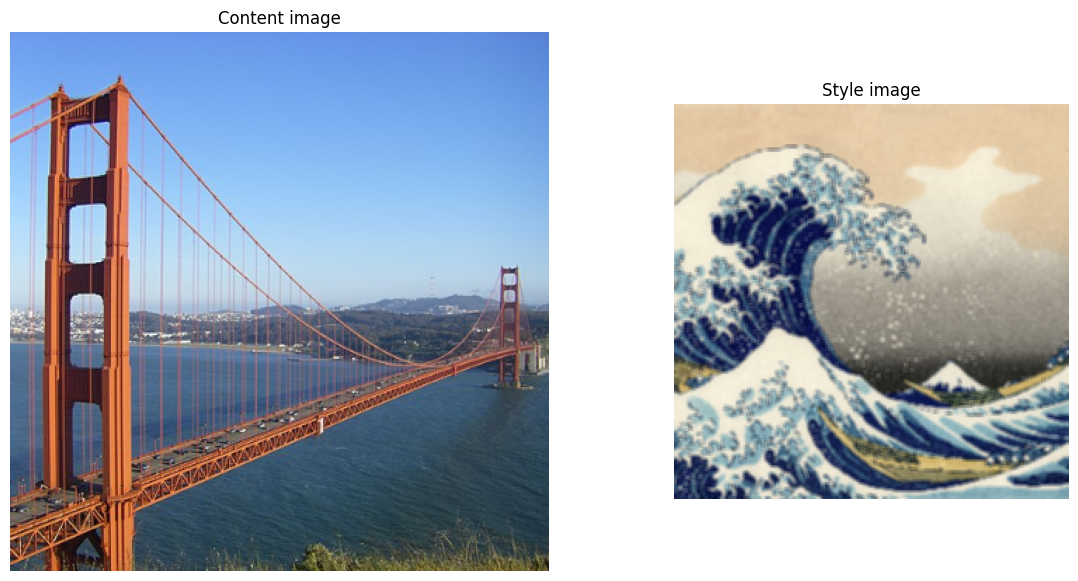

In [3]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

## Import TF Hub module

In [4]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.

In the current example we provide only single images and therefore the batch dimension is 1, but one can use the same module to process more images at the same time.

The input and output values of the images should be in the range [0, 1].

The shapes of content and style image don't have to match. Output image shape
is the same as the content image shape.

## Demonstrate image stylization

In [5]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

2023-04-27 14:23:25.621299: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


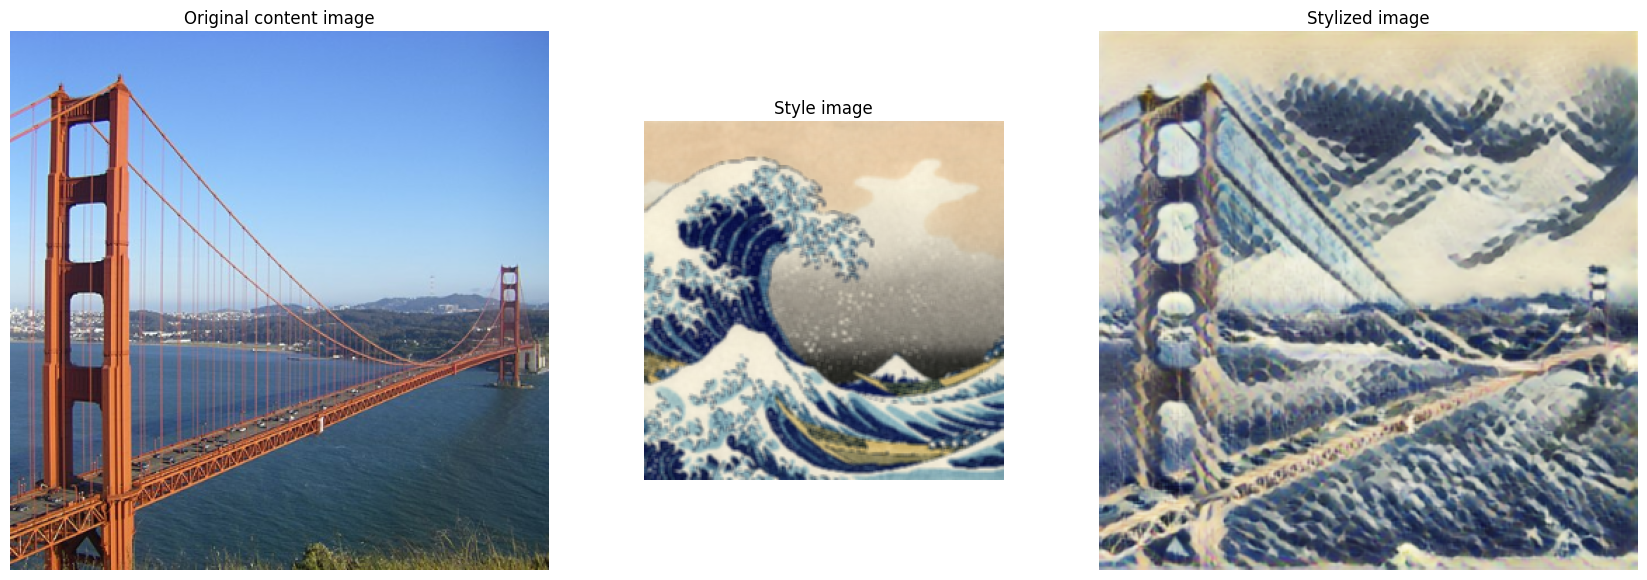

In [6]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

## Let's try it on more images

In [7]:
# @title To Run: Load more images { display-mode: "form" }

content_urls = dict(
  sea_turtle='https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg',
  tuebingen='https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg',
  grace_hopper='https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg',
  )
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

content_image_size = 384
style_image_size = 256
content_images = {k: load_image(v, (content_image_size, content_image_size)) for k, v in content_urls.items()}
style_images = {k: load_image(v, (style_image_size, style_image_size)) for k, v in style_urls.items()}
style_images = {k: tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME') for k, style_image in style_images.items()}


66306/66306 [==============================] - 0s 2us/step


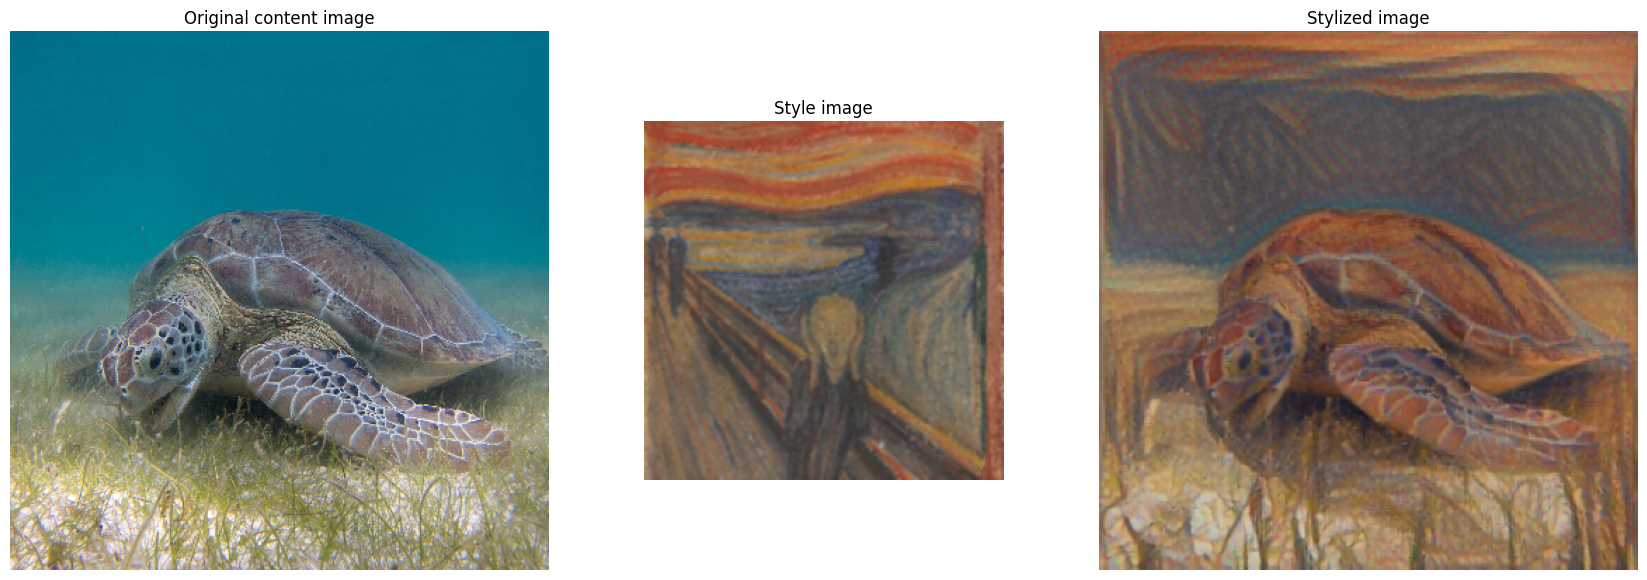

In [8]:
#@title Specify the main content image and the style you want to use.  { display-mode: "form" }

content_name = 'sea_turtle'  # @param ['sea_turtle', 'tuebingen', 'grace_hopper']
style_name = 'munch_scream'  # @param ['kanagawa_great_wave', 'kandinsky_composition_7', 'hubble_pillars_of_creation', 'van_gogh_starry_night', 'turner_nantes', 'munch_scream', 'picasso_demoiselles_avignon', 'picasso_violin', 'picasso_bottle_of_rum', 'fire', 'derkovits_woman_head', 'amadeo_style_life', 'derkovtis_talig', 'amadeo_cardoso']

stylized_image = hub_module(tf.constant(content_images[content_name]),
                            tf.constant(style_images[style_name]))[0]

show_n([content_images[content_name], style_images[style_name], stylized_image],
       titles=['Original content image', 'Style image', 'Stylized image'])